<a href="https://colab.research.google.com/github/yshnxd/solaris2/blob/main/SOLARISSS%20stablezzz%20finalzzzzz%2080%20%25%20with%20results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [2]:
# === STEP 0: Setup Libraries ===
# Core
import numpy as np
import pandas as pd
import gc
import os
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Technical indicators & TA-Lib alternative
!pip install ta --quiet
import ta

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
)

# XGBoost
!pip install xgboost --quiet
from xgboost import XGBClassifier, XGBRegressor

# Deep Learning (TensorFlow/Keras)
!pip install tensorflow --quiet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv1D, MaxPooling1D,
    LSTM, Input, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utilities for reproducibility
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries loaded successfully.")


  Preparing metadata (setup.py) ... done
✅ Libraries loaded successfully.


# Collect Data

In [3]:
# === STEP 1: Data Collection (Hourly) ===
!pip install yfinance --quiet
import yfinance as yf
from datetime import datetime
import pandas as pd
import os

# Target + market context tickers
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "NVDA", "AMD", "INTC", "META", "ORCL", "JPM", "GS", "BAC", "MS", "BRK-B", "JNJ", "PFE", "MRNA", "UNH", "LLY", "XOM", "CVX", "SLB", "BHP", "FCX", "CAT", "GE", "BA", "UPS", "NKE"]

interval = "60m"  # 1-hour bars
period = "729d"   # max allowed for hourly

data_dict = {}
print("Downloading hourly data...")
for t in tickers:
    try:
        df = yf.download(t, interval=interval, period=period, progress=False)
        df.dropna(inplace=True)
        df.index = df.index.tz_localize(None)
        data_dict[t] = df
        print(f"{t}: {df.shape[0]} rows from {df.index.min()} to {df.index.max()}")
    except Exception as e:
        print(f"❌ Failed to get {t}: {e}")
# ✅ Replace old close_df creation with this
target_index = data_dict["AAPL"].index
aligned_close = pd.DataFrame(index=target_index)

for t, df in data_dict.items():
    aligned_close[t] = df.reindex(target_index)['Close']

print("\nSample aligned close prices:")
print(aligned_close.tail())

# Save raw hourly data
os.makedirs("data_raw", exist_ok=True)
for t, df in data_dict.items():
    df.to_csv(f"data_raw/{t}_60m.csv")
print("\n✅ Hourly data downloaded and saved to 'data_raw/'")


AAPL: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
MSFT: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
AMZN: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
GOOGL: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
TSLA: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
NVDA: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
AMD: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
INTC: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
META: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
ORCL: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
JPM: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
GS: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
BAC: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
MS: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
BRK-B: 5075 rows from 2022-09-21 13:30:00 to 2025-08-18 19:30:00
JNJ: 5075 rows from 2022-09-21 13:30:00 to 20

#Feature Creation

Creating Features

In [4]:
all_feat_data = []

# Forward-fill aligned_close once globally
aligned_ffill = aligned_close.ffill()

for ticker in aligned_ffill.columns:
    if aligned_ffill[ticker].isna().all():
        continue

    price_series = aligned_ffill[ticker]
    feat_tmp = pd.DataFrame(index=price_series.index)

    # Lag returns
    for lag in [1, 3, 6, 12, 24]:
        feat_tmp[f"ret_{lag}h"] = price_series.pct_change(lag)

    # Rolling volatility
    for window in [6, 12, 24]:
        feat_tmp[f"vol_{window}h"] = price_series.pct_change().rolling(window).std()

    # Technical indicators
    feat_tmp["rsi_14"] = ta.momentum.RSIIndicator(price_series, window=14).rsi()
    macd = ta.trend.MACD(price_series)
    feat_tmp["macd"] = macd.macd()
    feat_tmp["macd_signal"] = macd.macd_signal()

    # Moving averages
    for w in [5, 10, 20]:
        feat_tmp[f"sma_{w}"] = price_series.rolling(w).mean()
        feat_tmp[f"ema_{w}"] = price_series.ewm(span=w, adjust=False).mean()

    # Volume features
    if ticker in data_dict and "Volume" in data_dict[ticker].columns:
        vol_series = data_dict[ticker].reindex(price_series.index)["Volume"].ffill()
        feat_tmp["vol_change_1h"] = vol_series.pct_change()
        feat_tmp["vol_ma_24h"] = vol_series.rolling(24).mean()

    # Cross-asset returns — from the globally ffilled dataframe
    for asset in ["MSFT", "AMZN", "GOOGL", "TSLA", "NVDA", "AMD", "INTC", "META", "ORCL", "JPM", "GS", "BAC", "MS", "BRK-B", "JNJ", "PFE", "MRNA", "UNH", "LLY", "XOM", "CVX", "SLB", "BHP", "FCX", "CAT", "GE", "BA", "UPS", "NKE"]:
        if asset in aligned_ffill.columns:
            feat_tmp[f"{asset}_ret_1h"] = aligned_ffill[asset].pct_change()


    # Calendar features
    feat_tmp["hour"] = feat_tmp.index.hour
    feat_tmp["day_of_week"] = feat_tmp.index.dayofweek

    # Only drop rows with NaNs in features for THIS ticker
    feat_tmp = feat_tmp.dropna(subset=[col for col in feat_tmp.columns if col not in ["datetime", "ticker"]])

    feat_tmp["datetime"] = feat_tmp.index
    feat_tmp["ticker"] = ticker

    all_feat_data.append(feat_tmp.reset_index(drop=True))

features_df = pd.concat(all_feat_data, ignore_index=True)

print(f"✅ Created features for {features_df['ticker'].nunique()} tickers")
print("Shape:", features_df.shape)
print(features_df.head())


✅ Created features for 30 tickers
Shape: (151260, 52)
     ret_1h    ret_3h    ret_6h   ret_12h   ret_24h    vol_6h   vol_12h  \
0  0.002674  0.004471  0.004308 -0.013460 -0.003374  0.007183  0.006754   
1  0.001518  0.003001 -0.006806  0.000231 -0.004306  0.004334  0.005802   
2 -0.028864 -0.024789 -0.028896 -0.023181 -0.031099  0.012247  0.010129   
3 -0.003528 -0.030821 -0.026487 -0.025871 -0.044381  0.012241  0.010132   
4  0.002043 -0.030313 -0.027403 -0.023233 -0.036346  0.012132  0.010198   

    vol_24h     rsi_14      macd  ...  FCX_ret_1h  CAT_ret_1h  GE_ret_1h  \
0  0.007743  47.572778 -0.591543  ...    0.007117    0.005894   0.011922   
1  0.007732  48.723831 -0.517296  ...    0.000186    0.001850  -0.000155   
2  0.009704  33.596049 -0.802639  ...    0.016549    0.024040   0.005271   
3  0.009391  32.313606 -1.058525  ...    0.004024   -0.004719  -0.003085   
4  0.009374  33.881947 -1.223012  ...    0.003279    0.002839  -0.003558   

   BA_ret_1h  UPS_ret_1h  NKE_ret_1h  

Label Creation

In [6]:
# === LABEL CREATION FOR ALL TICKERS (pooled dataset) ===

horizon = 1               # predict 1 hour ahead
vol_lookback = 24         # hours to compute rolling volatility
vol_multiplier = 0.5      # threshold scaling vs volatility

all_data = []

for ticker in aligned_close.columns:
    # Skip if ticker is all NaN (e.g., ^VIX alignment issues)
    if aligned_close[ticker].dropna().empty:
        continue

    price_series = aligned_close[ticker]

    # Forward return
    future_price = price_series.shift(-horizon)
    future_ret = (future_price - price_series) / price_series

    # Volatility-based threshold
    rolling_vol = price_series.pct_change().rolling(vol_lookback).std()
    threshold = rolling_vol * vol_multiplier

    # Label creation
    label = future_ret.copy()
    label[future_ret > threshold] = 1    # Up
    label[future_ret < -threshold] = -1  # Down
    label[(future_ret <= threshold) & (future_ret >= -threshold)] = 0  # Neutral

    # Drop NaNs
    label = label.dropna()

    # Combine into dataframe
    df_tmp = pd.DataFrame({
        "datetime": label.index,
        "ticker": ticker,
        "price": price_series.loc[label.index],
        "label": label.values,
        "future_ret": future_ret.loc[label.index],
        "volatility": rolling_vol.loc[label.index]
    })

    all_data.append(df_tmp)

# Combine all tickers
labels_df = pd.concat(all_data, ignore_index=True)

print("Combined dataset shape:", labels_df.shape)
print(labels_df["label"].value_counts(normalize=True))
labels_df.head(10)


Combined dataset shape: (152180, 6)
label
 0.000000    0.539138
 1.000000    0.234827
-1.000000    0.221317
 0.001518    0.000007
 0.001403    0.000007
               ...   
-0.002015    0.000007
-0.010123    0.000007
-0.003154    0.000007
-0.011338    0.000007
 0.001089    0.000007
Name: proportion, Length: 721, dtype: float64


,datetime,ticker,price,label,future_ret,volatility
0,2022-09-21 13:30:00,AAPL,157.389999,-0.007974,-0.007974,NaN
1,2022-09-21 14:30:00,AAPL,156.134995,0.006484,0.006484,NaN
2,2022-09-21 15:30:00,AAPL,157.147400,0.000538,0.000538,NaN
3,2022-09-21 16:30:00,AAPL,157.231995,-0.013553,-0.013553,NaN
4,2022-09-21 17:30:00,AAPL,155.100998,0.003927,0.003927,NaN
5,2022-09-21 18:30:00,AAPL,155.710007,-0.012844,-0.012844,NaN
6,2022-09-21 19:30:00,AAPL,153.710007,-0.008392,-0.008392,NaN
7,2022-09-22 13:30:00,AAPL,152.419998,-0.007873,-0.007873,NaN
8,2022-09-22 14:30:00,AAPL,151.220001,0.005376,0.005376,NaN
9,2022-09-22 15:30:00,AAPL,152.033005,0.002455,0.002455,NaN


Scaling

# Preprocessing

Normalize Features

In [7]:
# Merge features with labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Drop NaNs (just in case)
df = df.dropna()

# Separate features & labels
X = df.drop(columns=["datetime", "ticker", "label", "future_ret"])
y = df["label"]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))


X shape: (151190, 52)
y distribution:
 label
 0.0    0.541590
 1.0    0.236008
-1.0    0.222402
Name: proportion, dtype: float64


Scale

In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Merge features and labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Sort by time
df = df.sort_values(["datetime", "ticker"]).reset_index(drop=True)

# Replace inf values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaNs
df = df.dropna()

# Separate features & target
X = df.drop(columns=["datetime", "ticker", "label", "future_ret"])
y = df["label"]

# Time-based split
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# Ensure all values are finite before scaling
assert np.isfinite(X_train.values).all(), "Found non-finite values in X_train!"

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"✅ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Label distribution in Train:", y_train.value_counts(normalize=True))


✅ Train: (105812, 52), Val: (22674, 52), Test: (22675, 52)
Label distribution in Train: label
 0.0    0.537652
 1.0    0.239358
-1.0    0.222990
Name: proportion, dtype: float64


Sequence making - For LSTM AND CNN

In [13]:
import numpy as np

def create_sequences(X, y, seq_len=24):
    """
    Convert tabular (samples, features) into sequential (samples, seq_len, features)
    for CNN/LSTM, keeping labels aligned to the last timestep.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])  # label at next hour
    return np.array(X_seq), np.array(y_seq)

# === Choose sequence length ===
SEQ_LEN = 24  # last 24 hours to predict next hour

# Reshape train/val/test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, SEQ_LEN)
X_val_seq,   y_val_seq   = create_sequences(X_val,   y_val.values,   SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test.values,  SEQ_LEN)

print(f"Train seq: {X_train_seq.shape}, Val seq: {X_val_seq.shape}, Test seq: {X_test_seq.shape}")


Train seq: (105788, 24, 52), Val seq: (22650, 24, 52), Test seq: (22651, 24, 52)


In [14]:
# CELL 1 — label encoding + class weights
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# mapping: -1 -> 0 (down), 0 -> 1 (neutral), 1 -> 2 (up)
label_map = { -1.0: 0, 0.0: 1, 1.0: 2 }

# If your y_* are numpy arrays (seq labels), convert
y_train_seq_mapped = np.vectorize(label_map.get)(y_train_seq)
y_val_seq_mapped   = np.vectorize(label_map.get)(y_val_seq)
y_test_seq_mapped  = np.vectorize(label_map.get)(y_test_seq)

# one-hot for Keras
y_train_cat = to_categorical(y_train_seq_mapped, num_classes=3)
y_val_cat   = to_categorical(y_val_seq_mapped, num_classes=3)
y_test_cat  = to_categorical(y_test_seq_mapped, num_classes=3)

# compute class weights from training sequence labels
classes = np.unique(y_train_seq_mapped)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_seq_mapped)
class_weights_dict = {int(c): w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weights_dict)
print("Train class distribution:", np.bincount(y_train_seq_mapped) / len(y_train_seq_mapped))


Class weights: {0: np.float64(1.494497421770149), 1: np.float64(0.6200901518748425), 2: np.float64(1.392350417226039)}
Train class distribution: [0.22304042 0.53755624 0.23940333]


# Build the Model

CNN

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, Dropout, SpatialDropout1D,
    GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Add, Multiply, Concatenate
)
from tensorflow.keras.regularizers import l2

# AdamW optimizer (TF >=2.11), fallback to Adam
try:
    from tensorflow.keras.optimizers import experimental as exp_optimizers
    AdamW = exp_optimizers.AdamW
    use_adamw = True
except Exception:
    from tensorflow.keras.optimizers import Adam
    AdamW = None
    use_adamw = False

def se_block(x, reduction=8):
    channels = int(x.shape[-1])
    se = GlobalAveragePooling1D()(x)
    se = Dense(channels // reduction, activation='relu', kernel_initializer='he_normal')(se)
    se = Dense(channels, activation='sigmoid', kernel_initializer='he_normal')(se)
    se = tf.keras.layers.Reshape((1, channels))(se)
    return Multiply()([x, se])

def residual_block(x, filters, kernel_size, dropout_rate=0.2, weight_decay=1e-4):
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same',
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_cnn_enhanced_1m(input_shape, n_classes=3, dropout_rate=0.3, weight_decay=1e-4):
    inp = Input(shape=input_shape)

    # Input normalization
    x = BatchNormalization()(inp)

    # Initial Conv
    x = Conv1D(128, kernel_size=5, padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual block stack (much deeper & wider than original)
    x = residual_block(x, 128, 5, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = residual_block(x, 128, 5, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = se_block(x, reduction=8)

    x = residual_block(x, 256, 3, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = residual_block(x, 256, 3, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = se_block(x, reduction=8)

    x = residual_block(x, 512, 3, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = residual_block(x, 512, 3, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = se_block(x, reduction=8)

    x = residual_block(x, 1024, 3, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = se_block(x, reduction=16)

    # Pooling
    gap = GlobalAveragePooling1D()(x)
    gmp = GlobalMaxPooling1D()(x)
    x = Concatenate()([gap, gmp])

    # Dense stack (much wider for param count)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)

    if use_adamw and AdamW is not None:
        opt = AdamW(learning_rate=1e-3, weight_decay=1e-5)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Example usage:
cnn_model = build_cnn_enhanced_1m(input_shape=X_train_seq.shape[1:], n_classes=3)
cnn_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 24, 52)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 52)    │        208 │ input_layer_5[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 24, 128)   │     33,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 24, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 24, 128)   │     82,048 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 24, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 128)   │          0 │ activation_32[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 24, 128)   │     82,048 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 24, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 24, 128)   │          0 │ add_14[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 24, 128)   │     82,048 │ activation_33[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 24, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 128)   │          0 │ activation_34[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 24, 128)   │     82,048 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 12,220,547 (46.62 MB)

 Trainable params: 12,205,339 (46.56 MB)

 Non-trainable params: 15,208 (59.41 KB)

LSTM

In [24]:
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Concatenate, Attention
)
from tensorflow.keras.models import Model

def build_complex_lstm(input_shape, n_classes=3, dropout_rate=0.3):
    inp = Input(shape=input_shape)
    x = BatchNormalization()(inp)

    # First Bidirectional LSTM layer
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=dropout_rate))(x)
    x = Dropout(dropout_rate)(x)

    # Second Bidirectional LSTM layer
    x = Bidirectional(LSTM(192, return_sequences=True, dropout=dropout_rate))(x)
    x = Dropout(dropout_rate)(x)

    # Optional third layer for extra depth
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=dropout_rate))(x)
    x = Dropout(dropout_rate)(x)

    # Self-Attention
    attn = Attention()([x, x])
    x = Concatenate()([x, attn])

    # Global Pooling
    x_avg = GlobalAveragePooling1D()(x)
    x_max = GlobalMaxPooling1D()(x)
    x = Concatenate()([x_avg, x_max])

    # Wide dense stack
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(n_classes, activation='softmax')(x)
    model = Model(inp, out)
    return model

# Example usage:
model = build_complex_lstm(input_shape=(24, 52), n_classes=3)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 52)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 52)    │        208 │ input_layer_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 24, 512)   │    632,832 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 24, 512)   │          0 │ bidirectional_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 24, 384)   │  1,082,880 │ dropout_17[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 24, 384)   │          0 │ bidirectional_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 24, 256)   │    525,312 │ dropout_18[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 24, 256)   │          0 │ bidirectional_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 256)   │          0 │ dropout_19[0][0], │
│ (Attention)         │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 24, 512)   │          0 │ dropout_19[0][0], │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ concatenate_6[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ concatenate_6[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 1024)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 512)       │    524,800 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 512)       │          0 │ dense_45[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 256)       │    131,328 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,898,131 (11.06 MB)

 Trainable params: 2,898,027 (11.06 MB)

 Non-trainable params: 104 (416.00 B)

XGBOOST

In [31]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---- Map labels safely to integers 0,1,2 ----
label_map = {-1.0: 0, 0.0: 1, 1.0: 2}
# if y_train etc are pandas Series this is robust:
y_train_tab = pd.Series(y_train).map(label_map).astype('int').to_numpy()
y_val_tab   = pd.Series(y_val).map(label_map).astype('int').to_numpy()
y_test_tab  = pd.Series(y_test).map(label_map).astype('int').to_numpy()

# ---- Per-sample balanced weights (recommended for multiclass) ----
sample_weight_train = compute_sample_weight('balanced', y_train_tab)
# sample_weight_train is length n_train; pass it into .fit(..., sample_weight=...)

# ---- Defensive: compute per-class counts (avoid division by zero) ----
class_counts = np.bincount(y_train_tab, minlength=3)
total = len(y_train_tab)
n_classes = len(class_counts)
per_class_scale = np.where(class_counts == 0, 0.0, total / (n_classes * class_counts))
print("class_counts:", class_counts, "per_class_scale:", per_class_scale)

# If you prefer per-sample weights from per_class_scale:
sample_weight_from_scale = np.array([per_class_scale[c] for c in y_train_tab])

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    booster='dart',                 # Dropout trees for extra regularization
    tree_method='gpu_hist',         # Use GPU if available, else 'hist'
    n_estimators=3500,              # Very high, let early stopping prune
    learning_rate=0.01,             # Low for deep learning
    max_depth=13,                   # Very deep trees
    max_leaves=192,                 # More leaves per tree
    grow_policy='lossguide',        # Efficient deep trees
    max_bin=512,                    # Fine-grained split points
    min_child_weight=1.5,           # Lower for complex trees, but regularized
    colsample_bytree=0.98,
    colsample_bynode=0.85,
    subsample=0.95,
    gamma=3.5,                      # Strong pruning
    reg_alpha=0.02,                 # Lower L1 for more splits
    reg_lambda=4.0,                 # Higher L2 for strong regularization
    sampling_method='gradient_based',# Smarter sampling for large/imbalanced sets
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric=['mlogloss', 'auc', 'merror'],
    interaction_constraints=None,   # Specify if you have feature groups
    enable_categorical=True,        # If you have categorical features
)

class_counts: [23595 56890 25327] per_class_scale: [1.49483648 0.61998008 1.39261131]


# Train the model

CNN

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import datetime

# Enable mixed precision if supported
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile with lower LR initially for stability
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

chk = ModelCheckpoint(
    filepath='best_cnn_full_model.keras',  # save full model, not just weights
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# TensorBoard logging
log_dir = "logs/cnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training
cnn_history = cnn_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=100,
    batch_size=128,
    class_weight=class_weights_dict,
    callbacks=[es, rlr, chk, tb_callback],
    verbose=2
)


Epoch 1/100

Epoch 1: val_loss improved from inf to 2.32543, saving model to best_cnn_full_model.keras
827/827 - 109s - 132ms/step - accuracy: 0.3426 - loss: 2.7207 - val_accuracy: 0.2571 - val_loss: 2.3254 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 2.32543 to 1.81146, saving model to best_cnn_full_model.keras
827/827 - 74s - 90ms/step - accuracy: 0.3321 - loss: 2.0439 - val_accuracy: 0.2372 - val_loss: 1.8115 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 1.81146 to 1.42823, saving model to best_cnn_full_model.keras
827/827 - 40s - 49ms/step - accuracy: 0.4832 - loss: 1.6105 - val_accuracy: 0.5235 - val_loss: 1.4282 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 1.42823 to 1.25432, saving model to best_cnn_full_model.keras
827/827 - 45s - 55ms/step - accuracy: 0.4972 - loss: 1.3555 - val_accuracy: 0.5190 - val_loss: 1.2543 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 1.25432 t

LSTM

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import datetime

model = build_complex_lstm(input_shape=(24, 52), n_classes=3, dropout_rate=0.3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
chk = ModelCheckpoint(filepath='best_lstm_full_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
log_dir = "logs/lstm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=5)

history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=120,
    batch_size=128,
    class_weight=class_weights_dict,
    callbacks=[es, rlr, chk, tb_callback],
    verbose=2
)

Epoch 1/120

Epoch 1: val_loss improved from inf to 1.06158, saving model to best_lstm_full_model.keras
827/827 - 38s - 46ms/step - accuracy: 0.4475 - loss: 1.0858 - val_accuracy: 0.4984 - val_loss: 1.0616 - learning_rate: 3.0000e-04
Epoch 2/120

Epoch 2: val_loss improved from 1.06158 to 1.05564, saving model to best_lstm_full_model.keras
827/827 - 24s - 29ms/step - accuracy: 0.4721 - loss: 1.0776 - val_accuracy: 0.4883 - val_loss: 1.0556 - learning_rate: 3.0000e-04
Epoch 3/120

Epoch 3: val_loss did not improve from 1.05564
827/827 - 41s - 49ms/step - accuracy: 0.4772 - loss: 1.0718 - val_accuracy: 0.4726 - val_loss: 1.0634 - learning_rate: 3.0000e-04
Epoch 4/120

Epoch 4: val_loss improved from 1.05564 to 1.05096, saving model to best_lstm_full_model.keras
827/827 - 41s - 49ms/step - accuracy: 0.4766 - loss: 1.0649 - val_accuracy: 0.5102 - val_loss: 1.0510 - learning_rate: 3.0000e-04
Epoch 5/120

Epoch 5: val_loss did not improve from 1.05096
827/827 - 41s - 49ms/step - accuracy: 0.

XGBOOST

In [37]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# --- Label mapping ---
label_map = {-1.0: 0, 0.0: 1, 1.0: 2}
y_train_tab = pd.Series(y_train).map(label_map).astype(int).to_numpy()
y_val_tab   = pd.Series(y_val).map(label_map).astype(int).to_numpy()
y_test_tab  = pd.Series(y_test).map(label_map).astype(int).to_numpy()

# --- Sample weights ---
sw_train = compute_sample_weight(class_weight='balanced', y=y_train_tab)
sw_val   = compute_sample_weight(class_weight='balanced', y=y_val_tab)

# --- DMatrix for train/val/test ---
dtrain = xgb.DMatrix(X_train, label=y_train_tab, weight=sw_train)
dval   = xgb.DMatrix(X_val, label=y_val_tab, weight=sw_val)
dtest  = xgb.DMatrix(X_test)

def predict_with_best(booster: xgb.Booster, dmatrix: xgb.DMatrix):
    try:
        if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
            return booster.predict(dmatrix, iteration_range=(0, int(booster.best_iteration) + 1))
    except TypeError:
        pass
    try:
        if hasattr(booster, "best_ntree_limit") and booster.best_ntree_limit is not None:
            return booster.predict(dmatrix, ntree_limit=int(booster.best_ntree_limit))
    except TypeError:
        pass
    return booster.predict(dmatrix)

# --- Complex XGBoost Training ---
params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "booster": "dart",                # Use DART for dropout regularization
    "tree_method": "gpu_hist",        # Use GPU if available
    "seed": 42,
    "verbosity": 1,
    "max_depth": 13,
    "max_leaves": 192,
    "grow_policy": "lossguide",
    "max_bin": 512,
    "learning_rate": 0.012,
    "subsample": 0.92,
    "colsample_bytree": 0.97,
    "colsample_bynode": 0.85,
    "gamma": 3.5,
    "min_child_weight": 2,
    "reg_alpha": 0.02,
    "reg_lambda": 4.0,
    "sampling_method": "gradient_based",
    "rate_drop": 0.05,
    "skip_drop": 0.2,
    "sample_type": "uniform",
    "normalize_type": "forest",
}

final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=3500,
    evals=[(dtrain, "train"), (dval, "eval")],
    early_stopping_rounds=150,
    verbose_eval=100
)

# --- Save model ---
final_model.save_model("xgb_model_max.json")
joblib.dump(final_model, "xgb_model_max.pkl")

# --- Evaluate on test set ---
y_prob = predict_with_best(final_model, dtest)
y_pred = np.argmax(y_prob, axis=1)

print("Final Test Accuracy:", accuracy_score(y_test_tab, y_pred))
print("\nClassification report:\n", classification_report(y_test_tab, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test_tab, y_pred))

[0]	train-mlogloss:1.09645	eval-mlogloss:1.09788
[100]	train-mlogloss:0.96314	eval-mlogloss:1.06550
[200]	train-mlogloss:0.88956	eval-mlogloss:1.06166
[300]	train-mlogloss:0.83945	eval-mlogloss:1.06270
[354]	train-mlogloss:0.81985	eval-mlogloss:1.06334
Final Test Accuracy: 0.5174421168687983

Classification report:
               precision    recall  f1-score   support

           0       0.27      0.25      0.26      4842
           1       0.66      0.72      0.69     12567
           2       0.32      0.28      0.30      5266

    accuracy                           0.52     22675
   macro avg       0.42      0.42      0.42     22675
weighted avg       0.50      0.52      0.51     22675


Confusion matrix:
 [[1202 2332 1308]
 [1749 9064 1754]
 [1506 2293 1467]]


# O-O-F Predictions

In [38]:
# Use correct aligned length (should match X_train_seq or X_tab_aligned)
n_samples = X_train_seq.shape[0]  # or X_tab_aligned.shape[0], should be 17607
oof_cnn = np.zeros((n_samples, 3))
oof_lstm = np.zeros((n_samples, 3))
oof_xgb = np.zeros((n_samples, 3))

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

# ==== Combine your split data back into one dataset ====
X_tab = np.vstack([X_train, X_val, X_test])
y_tab = np.concatenate([y_train, y_val, y_test])
y_tab = pd.Series(y_tab)  # needed for .map()

# ==== Time series split config ====
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# ==== Label remap (-1, 0, 1) -> (0, 1, 2) ====
label_map = {-1: 0, 0: 1, 1: 2}

# ==== One-hot encoder for DL models ====
enc = OneHotEncoder(sparse_output=False)
y_all_mapped = y_tab.map(label_map)
y_all_oh = enc.fit_transform(y_all_mapped.values.reshape(-1, 1))

# ==== Align all arrays to the same length ====
min_len = min(len(X_tab), len(X_train_seq), len(y_all_mapped))

X_tab_aligned = X_tab[:min_len]
X_train_seq_aligned = X_train_seq[:min_len]
y_all_mapped_aligned = y_all_mapped.iloc[:min_len]
y_all_oh_aligned = y_all_oh[:min_len]

print(f"Aligned lengths: tab={X_tab_aligned.shape}, seq={X_train_seq_aligned.shape}, y={y_all_mapped_aligned.shape}")

Aligned lengths: tab=(105788, 52), seq=(105788, 24, 52), y=(105788,)


In [40]:
print("=== Generating CNN OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Sequences
    X_seq_tr, X_seq_va = X_train_seq_aligned[train_idx], X_train_seq_aligned[val_idx]
    y_seq_tr_oh, y_seq_va_oh = y_all_oh_aligned[train_idx], y_all_oh_aligned[val_idx]
    # Build + compile
    cnn_model = build_cnn_enhanced_1m(input_shape=X_seq_tr.shape[1:], n_classes=3, dropout_rate=0.25)
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train
    cnn_model.fit(X_seq_tr, y_seq_tr_oh, validation_data=(X_seq_va, y_seq_va_oh),
                  epochs=5, batch_size=64, verbose=0)
    # Predict
    oof_cnn[val_idx] = cnn_model.predict(X_seq_va, verbose=0)

=== Generating CNN OOF predictions ===

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---


In [41]:
print("=== Generating LSTM OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Sequences
    X_seq_tr, X_seq_va = X_train_seq_aligned[train_idx], X_train_seq_aligned[val_idx]
    y_seq_tr_oh, y_seq_va_oh = y_all_oh_aligned[train_idx], y_all_oh_aligned[val_idx]
    # Build + compile
    lstm_model = build_complex_lstm(input_shape=X_seq_tr.shape[1:], n_classes=3, dropout_rate=0.25)
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train
    lstm_model.fit(X_seq_tr, y_seq_tr_oh, validation_data=(X_seq_va, y_seq_va_oh),
                   epochs=5, batch_size=64, verbose=0)
    # Predict
    oof_lstm[val_idx] = lstm_model.predict(X_seq_va, verbose=0)

=== Generating LSTM OOF predictions ===

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---


In [42]:
from xgboost import XGBClassifier

print("=== Generating XGB OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Tabular split
    X_tr_tab, X_va_tab = X_tab_aligned[train_idx], X_tab_aligned[val_idx]
    y_tr_tab, y_va_tab = y_all_mapped_aligned.iloc[train_idx], y_all_mapped_aligned.iloc[val_idx]
    # Build with best parameters
    xgb_clf = XGBClassifier(params)
    # Train
    xgb_clf.fit(X_tr_tab, y_tr_tab)
    # Predict
    oof_xgb[val_idx] = xgb_clf.predict_proba(X_va_tab)

# After all OOF prediction cells (CNN, LSTM, XGB)
oof_idx_xgb = np.concatenate([val_idx for _, val_idx in tscv.split(X_tab_aligned)])
print("oof_idx_xgb shape:", oof_idx_xgb.shape)

=== Generating XGB OOF predictions ===

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---
oof_idx_xgb shape: (88155,)


In [43]:
import joblib

joblib.dump(
    {
        "oof_cnn": oof_cnn,
        "oof_lstm": oof_lstm,
        "oof_xgb": oof_xgb,
        "y": y_all_mapped_aligned.values
    },
    "oof_preds.pkl"
)
print("💾 OOF predictions saved to oof_preds.pkl")

💾 OOF predictions saved to oof_preds.pkl


In [44]:
idx = np.asarray(oof_idx_xgb)  # shape (17607,)
oof_cnn_aligned = np.asarray(oof_cnn)[idx]
oof_lstm_aligned = np.asarray(oof_lstm)[idx]
oof_xgb_aligned = np.asarray(oof_xgb)[idx]
print("Aligned shapes:", oof_cnn_aligned.shape, oof_lstm_aligned.shape, oof_xgb_aligned.shape)

Aligned shapes: (88155, 3) (88155, 3) (88155, 3)


# META LEARNER

In [45]:
import numpy as np

# 1) Ensure the XGB index mapping exists
if 'oof_idx_xgb' not in globals():
    raise RuntimeError("oof_idx_xgb not found. Re-run XGB OOF generation to set oof_idx_xgb.")

idx = np.asarray(oof_idx_xgb)

# 2) Select aligned rows from CNN/LSTM using that mapping
aligned_cnn = np.asarray(oof_cnn)[idx]
aligned_lstm = np.asarray(oof_lstm)[idx]
aligned_xgb = np.asarray(oof_xgb)[idx]  # <-- FIX: select only aligned rows!

# 3) Sanity checks
assert aligned_cnn.shape[0] == aligned_lstm.shape[0] == aligned_xgb.shape[0], \
       f"Aligned shapes mismatch: cnn {aligned_cnn.shape} lstm {aligned_lstm.shape} xgb {aligned_xgb.shape}"

# 4) Build meta matrices (stacked probabilities)
meta_X_train = np.hstack([aligned_cnn, aligned_lstm, aligned_xgb])  # shape: (N_aligned, 9)

# Use the y that matches the aligned samples
if 'y_all_mapped_aligned' in globals():
    meta_y_train = np.asarray(y_all_mapped_aligned)[idx]
else:
    # If not available, fallback to y_all_mapped (full length)
    meta_y_train = np.asarray(y_all_mapped)[idx]

print("meta_X_train shape:", meta_X_train.shape)
print("meta_y_train shape:", meta_y_train.shape)

meta_X_train shape: (88155, 9)
meta_y_train shape: (88155,)


In [46]:
# Cell B — meta-features construction
import numpy as np
import pandas as pd

# Stack base model probabilities as features
meta_probs = np.hstack([oof_cnn, oof_lstm, oof_xgb])  # shape (n, 9)

# Add engineered meta-features derived from base model outputs:
# - per-sample mean/std/max/min across base model probs
# - disagreements (max prob - 2nd max prob) for confidence
def meta_stats_from_probs(probs_block):
    # probs_block shape (n, n_models * n_classes)
    n_classes = 3
    n_models = probs_block.shape[1] // n_classes
    block = probs_block.reshape(len(probs_block), n_models, n_classes)
    # per model best class prob and best class
    best_probs = block.max(axis=2)                 # (n, n_models)
    best_classes = block.argmax(axis=2)             # (n, n_models)
    # statistics across models on best_probs
    mean_best = best_probs.mean(axis=1)
    std_best = best_probs.std(axis=1)
    max_best = best_probs.max(axis=1)
    min_best = best_probs.min(axis=1)
    # disagreement: how many models agree with majority class
    from scipy.stats import mode
    mode_vals, mode_counts = mode(best_classes, axis=1)
    agree_fraction = (mode_counts.ravel() / n_models)
    # confidence gap: top prob - second top prob per model averaged
    def gap_per_row(row_block):
        # row_block shape (n_models, n_classes)
        gaps = []
        for m in range(row_block.shape[0]):
            arr = np.sort(row_block[m])[::-1]
            gaps.append(arr[0] - (arr[1] if arr.shape[0] > 1 else 0.0))
        return np.mean(gaps)
    gap = np.array([gap_per_row(row) for row in block])

    stats = np.vstack([mean_best, std_best, max_best, min_best, agree_fraction, gap]).T
    stats_cols = ["mean_best_prob", "std_best_prob", "max_best_prob", "min_best_prob", "agree_frac", "avg_top_gap"]
    return stats, stats_cols

stats, stats_cols = meta_stats_from_probs(meta_probs)

# Optionally add a few simple original features if available (e.g. last-hour vol, last return).
# If you saved a features/labels DataFrame earlier, load and align here:
# features_df = pd.read_parquet("features_aligned.parquet")  # or load whatever you have
# extra_feats = features_df.loc[:n-1, ["vol_24h", "ret_1h"]].to_numpy()

# For now, we'll build final meta_X from probs + stats
meta_X = np.hstack([meta_probs, stats])
meta_feature_names = (
    [f"cnn_p{c}" for c in range(3)] +
    [f"lstm_p{c}" for c in range(3)] +
    [f"xgb_p{c}" for c in range(3)] +
    stats_cols
)

print("Meta X shape:", meta_X.shape)
print("Feature names:", meta_feature_names)


Meta X shape: (105788, 15)
Feature names: ['cnn_p0', 'cnn_p1', 'cnn_p2', 'lstm_p0', 'lstm_p1', 'lstm_p2', 'xgb_p0', 'xgb_p1', 'xgb_p2', 'mean_best_prob', 'std_best_prob', 'max_best_prob', 'min_best_prob', 'agree_frac', 'avg_top_gap']


In [47]:
# ---------- Train final meta-learner on aligned meta features (fix mismatch) ----------
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import numpy as np

# Use aligned meta arrays produced earlier
if 'meta_X_train' in globals() and 'meta_y_train' in globals():
    X_meta = np.asarray(meta_X_train)
    y_meta = np.asarray(meta_y_train)
else:
    raise RuntimeError("Aligned meta arrays not found. Make sure meta_X_train and meta_y_train exist.")

print("Shapes before fit: X_meta:", X_meta.shape, "y_meta:", y_meta.shape)

# sanity
if X_meta.shape[0] != y_meta.shape[0]:
    raise ValueError(f"Shape mismatch: X_meta rows {X_meta.shape[0]} != y_meta {y_meta.shape[0]}")

# compute balanced sample weights for the meta set
sample_weight_meta = compute_sample_weight(class_weight="balanced", y=y_meta)

# build final model with the best hyperparameters found earlier (best_cfg)
# make sure best_cfg exists; if not, you can hardcode the best config you printed
try:
    best_cfg  # noqa: F821
except NameError:
    # fallback: use the best config you printed: {'max_iter':200,'learning_rate':0.1,'max_depth':4}
    best_cfg = {'max_iter': 200, 'learning_rate': 0.1, 'max_depth': 4}

final_model = HistGradientBoostingClassifier(**best_cfg, early_stopping=True, random_state=42)
final_model.fit(X_meta, y_meta, sample_weight=sample_weight_meta)

# Save the trained meta model
joblib.dump(final_model, "meta_learner.pkl")
print("Final meta_learner model trained and saved to meta_laerner.pkl")

# Quick train-set diagnostics
from sklearn.metrics import classification_report, balanced_accuracy_score
pred_train = final_model.predict(X_meta)
print("Train balanced accuracy:", balanced_accuracy_score(y_meta, pred_train))
print("Train classification report:\n", classification_report(y_meta, pred_train, digits=4))


Shapes before fit: X_meta: (88155, 9) y_meta: (88155,)
Final meta_learner model trained and saved to meta_laerner.pkl
Train balanced accuracy: 0.616637361840413
Train classification report:
               precision    recall  f1-score   support

           0     0.4985    0.6350    0.5585     19787
           1     0.7490    0.5837    0.6561     47293
           2     0.5098    0.6313    0.5641     21075

    accuracy                         0.6066     88155
   macro avg     0.5858    0.6166    0.5929     88155
weighted avg     0.6356    0.6066    0.6122     88155



In [48]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from typing import Optional

def load_and_predict(
    model_path: str,
    meta_X: np.ndarray,
    y: Optional[np.ndarray] = None,
    threshold: Optional[np.ndarray] = None,
    label_map_back: Optional[dict] = None,  # e.g. {0:-1.0, 1:0.0, 2:1.0}
    verbose: bool = True
):
    """
    Loads a saved meta model (or a dict with 'meta_model' and optional 'calibrators'),
    restricts meta_X to 9 features, predicts probabilities and classes, applies optional thresholding,
    and returns (probs, preds, preds_mapped_if_label_map).
    """
    assert isinstance(meta_X, np.ndarray), "meta_X must be a numpy array"

    # --- force only 9 features ---
    if meta_X.shape[1] > 9:
        if verbose:
            print(f"[INFO] meta_X has {meta_X.shape[1]} features, truncating to first 9.")
        meta_X = meta_X[:, :9]
    elif meta_X.shape[1] < 9:
        raise ValueError(f"meta_X has {meta_X.shape[1]} features, but at least 9 are required.")

    # --- FIX: accept both 'meta_learner.pkl' and 'meta_model.pkl' as input ---
    try:
        obj = joblib.load(model_path)
    except FileNotFoundError as e:
        if model_path == "meta_model.pkl":
            print("[WARN] meta_model.pkl not found, trying meta_learner.pkl instead.")
            obj = joblib.load("meta_learner.pkl")
        else:
            raise

    # object can be:
    # - a fitted estimator with predict_proba
    # - a dict: {'meta_model': estimator, 'calibrators': [cal1, cal2, ...]} or similar
    if isinstance(obj, dict):
        if verbose:
            print("Loaded dict artifact with keys:", list(obj.keys()))
        meta_model = obj.get("meta_model") or obj.get("model") or obj.get("estimator")
        calibrators = obj.get("calibrators", None)
    else:
        if verbose:
            print("Loaded estimator directly from", model_path)
        meta_model = obj
        calibrators = None

    if meta_model is None:
        raise RuntimeError("No 'meta_model' found in artifact and artifact is not a direct estimator.")

    # Get probabilities
    if calibrators:
        if verbose:
            print("Using calibrators to produce averaged probabilities (len calibrators):", len(calibrators))
        probs_list = []
        for cal in calibrators:
            if hasattr(cal, "predict_proba"):
                probs_list.append(cal.predict_proba(meta_X))
            elif hasattr(cal, "predict"):
                preds = cal.predict(meta_X)
                onehot = np.zeros((len(preds), np.max(preds)+1))
                onehot[np.arange(len(preds)), preds] = 1.0
                probs_list.append(onehot)
            else:
                raise RuntimeError("Calibrator does not support predict_proba or predict.")
        probs = np.mean(probs_list, axis=0)
    else:
        if not hasattr(meta_model, "predict_proba"):
            raise RuntimeError("Loaded meta_model has no predict_proba method.")
        probs = meta_model.predict_proba(meta_X)

    # Optional thresholding
    if threshold is not None:
        threshold = np.asarray(threshold)
        if threshold.shape[0] != probs.shape[1]:
            raise ValueError("threshold must have length equal to number of classes")
        scores = probs - threshold.reshape((1, -1))
        preds = np.argmax(scores, axis=1)
    else:
        preds = np.argmax(probs, axis=1)

    # Map back to original labels
    preds_mapped = None
    if label_map_back is not None:
        preds_mapped = np.array([label_map_back[int(p)] for p in preds])

    # Diagnostics
    if y is not None:
        if len(y) != len(preds):
            raise ValueError(f"Length mismatch: y ({len(y)}) vs preds ({len(preds)})")
        acc = accuracy_score(y, preds)
        f1m = f1_score(y, preds, average="macro", zero_division=0)
        if verbose:
            print(f"Accuracy: {acc:.4f}   F1_macro: {f1m:.4f}")
            print(classification_report(y, preds, digits=4))
    else:
        if verbose:
            print("No ground-truth y provided; returning predictions only.")

    return probs, preds, preds_mapped


# save

In [49]:
import joblib

joblib.dump(final_model, "meta_learner.pkl")


['meta_learner.pkl']

In [50]:
from google.colab import files
files.download("meta_learner.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
import joblib
from google.colab import files

# Save the three base models
joblib.dump(cnn_model, "cnn_model.pkl")
joblib.dump(lstm_model, "lstm_model.pkl")
joblib.dump(xgb_clf, "xgb_model.pkl")  # change to your actual XGB var name

# Download them
files.download("cnn_model.pkl")
files.download("lstm_model.pkl")
files.download("xgb_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
import joblib
joblib.dump(scaler, "scaler.pkl")
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Summary metrics per model ===


,Accuracy,Macro_F1,F1_Down(-1),F1_Neutral(0),F1_Up(1)
Model,,,,,
XGB,0.4808,0.3672,0.2525,0.6480,0.2012
LSTM,0.5569,0.4758,0.4119,0.6774,0.3382
CNN,0.5572,0.4841,0.4037,0.6734,0.3751
META,0.5456,0.5374,0.5150,0.5890,0.5083



=== Full classification reports ===

--- CNN ---
              precision    recall  f1-score   support

   Down (-1)     0.3700    0.4443    0.4037     23592
 Neutral (0)     0.6213    0.7351    0.6734     56877
      Up (1)     0.6545    0.2629    0.3751     25319

    accuracy                         0.5572    105788
   macro avg     0.5486    0.4807    0.4841    105788
weighted avg     0.5732    0.5572    0.5419    105788


--- LSTM ---
              precision    recall  f1-score   support

   Down (-1)     0.3749    0.4570    0.4119     23592
 Neutral (0)     0.6213    0.7447    0.6774     56877
      Up (1)     0.6527    0.2282    0.3382     25319

    accuracy                         0.5569    105788
   macro avg     0.5496    0.4766    0.4758    105788
weighted avg     0.5738    0.5569    0.5370    105788


--- XGB ---
              precision    recall  f1-score   support

   Down (-1)     0.2433    0.2625    0.2525     23592
 Neutral (0)     0.5876    0.7222    0.6480     5687

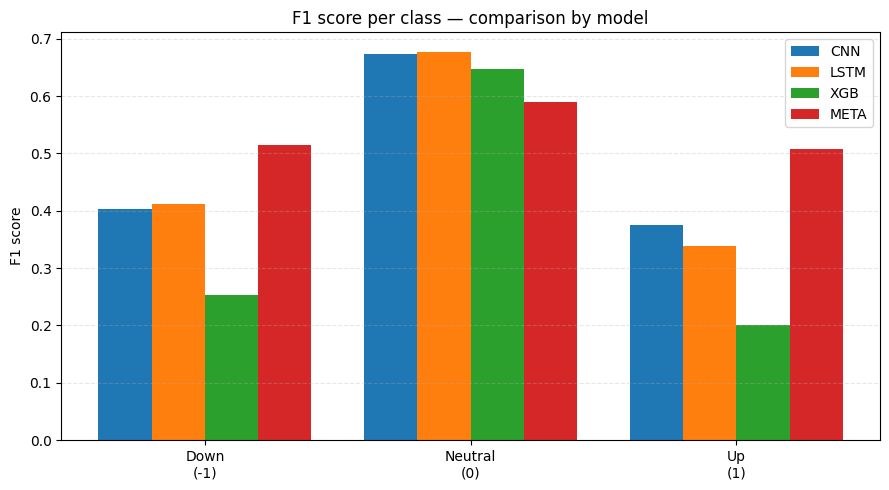

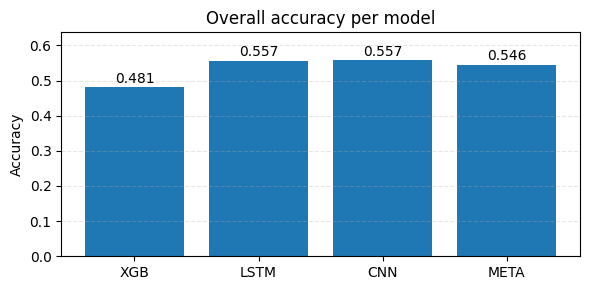


Best model by Macro_F1: META



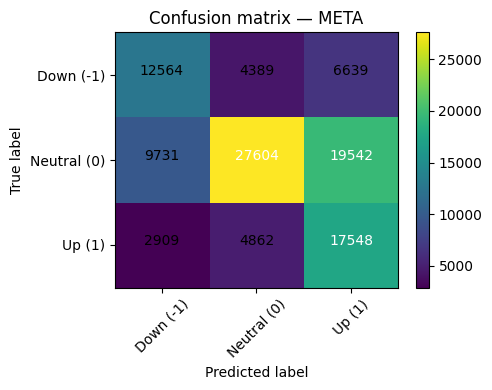

Saved model_metrics_summary.csv


In [53]:
# === Consolidated metrics & plots ===
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

# ---- config ----
oof_path = "oof_preds.pkl"    # created by the notebook
meta_model_path = "meta_learner.pkl"  # created by the notebook (optional)
inv_label_map = {0: -1.0, 1: 0.0, 2: 1.0}  # back to original labels; adjust if your mapping differs
class_names = ["Down (-1)", "Neutral (0)", "Up (1)"]
models_to_eval = ["cnn", "lstm", "xgb", "meta"]

# ---- load OOFs ----
if not os.path.exists(oof_path):
    raise FileNotFoundError(f"{oof_path} not found. Run the OOF generation cells (35-37 + save).")

data = joblib.load(oof_path)
# Expect keys: "oof_cnn", "oof_lstm", "oof_xgb", "y"
oof_cnn = data.get("oof_cnn")
oof_lstm = data.get("oof_lstm")
oof_xgb = data.get("oof_xgb")
y_all = data.get("y")

if y_all is None:
    raise RuntimeError("True labels 'y' not present in oof_preds.pkl - check saving step.")

# Normalize shape handling:
def probs_to_preds(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr.astype(int)
    if arr.ndim == 2:
        return np.argmax(arr, axis=1)
    raise ValueError("Unexpected array shape for model outputs: %s" % (arr.shape,))

preds = {}
probs = {}
for name, arr in [("cnn", oof_cnn), ("lstm", oof_lstm), ("xgb", oof_xgb)]:
    if arr is None:
        print(f"[WARN] {name} OOF not found in {oof_path}.")
        continue
    arr = np.asarray(arr)
    probs[name] = arr
    preds[name] = probs_to_preds(arr)

# Meta (try to compute, if possible)
meta_available = False
if os.path.exists(meta_model_path):
    try:
        meta_model = joblib.load(meta_model_path)
        # Try to construct meta_X if saved inside oof file under a key (some notebooks store meta_X)
        meta_X = data.get("meta_X", None)
        if meta_X is None:
            # try to build from stacked probs if present
            if all(k in probs for k in ["cnn","lstm","xgb"]):
                stacked = np.hstack([probs["cnn"], probs["lstm"], probs["xgb"]])
                # if meta model expects extra features, this may fail — we fall back to skipping
                meta_X = stacked
        if meta_X is not None:
            meta_probs = meta_model.predict_proba(meta_X)
            preds["meta"] = np.argmax(meta_probs, axis=1)
            probs["meta"] = meta_probs
            meta_available = True
        else:
            print("[WARN] meta_X not found and could not be constructed; skipping meta evaluation.")
    except Exception as e:
        print("[WARN] failed to load/score meta model:", e)
else:
    print("[INFO] meta_learner.pkl not found; skipping meta evaluation.")

# convert y to ints if necessary
y_true = np.asarray(y_all).astype(int)

# ---- compute metrics per model ----
rows = []
per_class_f1 = {}
for m in ["cnn", "lstm", "xgb", "meta"]:
    if m not in preds:
        continue
    p = preds[m]
    acc = accuracy_score(y_true, p)
    prec = precision_score(y_true, p, average=None, labels=[0,1,2], zero_division=0)
    rec = recall_score(y_true, p, average=None, labels=[0,1,2], zero_division=0)
    f1s = f1_score(y_true, p, average=None, labels=[0,1,2], zero_division=0)
    macro_f1 = f1_score(y_true, p, average="macro", zero_division=0)
    rows.append({
        "Model": m.upper(),
        "Accuracy": acc,
        "Macro_F1": macro_f1,
        "F1_Down(-1)": f1s[0],
        "F1_Neutral(0)": f1s[1],
        "F1_Up(1)": f1s[2]
    })
    per_class_f1[m] = f1s

df_metrics = pd.DataFrame(rows).set_index("Model")
# Reorder rows (if meta missing it will be absent)
df_metrics = df_metrics.loc[[r for r in ["XGB","LSTM","CNN","META"] if r in df_metrics.index]]

# pretty print
pd.options.display.float_format = "{:0.4f}".format
print("\n=== Summary metrics per model ===")
display(df_metrics)

# ---- Table by class with precision/recall/f1 (full classification report) ----
print("\n=== Full classification reports ===")
for m in ["cnn","lstm","xgb","meta"]:
    if m not in preds:
        continue
    print(f"\n--- {m.upper()} ---")
    print(classification_report(y_true, preds[m], target_names=class_names, digits=4))

# ---- Plots: grouped bar chart of F1 per class & accuracy bar ----
models = list(per_class_f1.keys())
n_models = len(models)
classes_idx = [0,1,2]
width = 0.2
x = np.arange(len(classes_idx))

plt.figure(figsize=(9,5))
for i, m in enumerate(models):
    f1vals = per_class_f1[m]
    plt.bar(x + (i - (n_models-1)/2)*width, f1vals, width=width, label=m.upper())
plt.xticks(x, ["Down\n(-1)","Neutral\n(0)","Up\n(1)"])
plt.ylabel("F1 score")
plt.title("F1 score per class — comparison by model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy bar chart
plt.figure(figsize=(6,3))
accs = [df_metrics.loc[m.upper(), "Accuracy"] for m in df_metrics.index]
plt.bar(df_metrics.index, accs)
plt.ylabel("Accuracy")
plt.title("Overall accuracy per model")
for i,v in enumerate(accs):
    plt.text(i, v+0.005, f"{v:.3f}", ha='center', va='bottom')
plt.ylim(0, max(accs)+0.08)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Confusion matrix heatmap for best model by Macro_F1 ----
best_model = df_metrics["Macro_F1"].idxmax().lower()
print(f"\nBest model by Macro_F1: {best_model.upper()}\n")

cm = confusion_matrix(y_true, preds[best_model], labels=[0,1,2])
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title(f"Confusion matrix — {best_model.upper()}")
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.xticks([0,1,2], class_names, rotation=45)
plt.yticks([0,1,2], class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ---- save table CSV ----
df_metrics.to_csv("model_metrics_summary.csv")
print("Saved model_metrics_summary.csv")


In [ ]:
from google.colab import files
files.download("model_metrics_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>